In [1]:
from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# factor analysis mixed data types
import prince
from sklearn.decomposition import PCA
# seed
RANDOM_STATE = 1776

# set seaborn theme
sns.set_theme()

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())
print("Prince Version: " + prince.__version__)

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20
Prince Version: 0.13.0


### Import Datasets

In [2]:
# full dataframe
df = pd.read_pickle("../Data/DF5_Analysis.pkl")

# data dictionary
df_dict = pd.read_pickle("../Data/FinalcolumnDefinition.pkl")

# data label
df_label = pd.read_pickle("../Data/Label_Analysis.pkl") 

# data unknown
df_unknown = pd.read_pickle("../Data/Unknown_Analysis.pkl")

# remove columns
df_remove = pd.read_pickle("../Data/Remove_Analysis.pkl")

# new columns
df_new = pd.read_pickle("../Data/New_Analysis.pkl")

# can columns
df_can = pd.read_pickle("../Data/CAN_Analysis.pkl")

# don columns
df_don = pd.read_pickle("../Data/DON_Analysis.pkl")

# both columns
df_both = pd.read_pickle("../Data/Both_Analysis.pkl")

# checking for duplicated column name
df.columns[df.columns.duplicated()]

Index([], dtype='object')

In [3]:
# df DataFrame
print(f"Orginal Data file Shape: {df.shape}")
print(f"Label(s) Data rows: {len(df_label)}")
print(f"Remove Column(s) Data rows: {len(df_remove)}")
print(f"Donor Column(s) Data rows: {len(df_don)}")
print(f"Candidate Column(s) Data rows: {len(df_can)}")
print(f"Both Column(s) Data rows: {len(df_both)}")

Orginal Data file Shape: (15282, 278)
Label(s) Data rows: 12
Remove Column(s) Data rows: 78
Donor Column(s) Data rows: 87
Candidate Column(s) Data rows: 157
Both Column(s) Data rows: 29


### User Function(s)

In [4]:
def percentageNull(df):
    """
    Calculate percentage of NaN & NaN count
    """
    # calculate the percentage of non-null values for each column
    per_calc = pd.DataFrame(100 - (df.count() / len(df) * 100))
    
    # rename columns name
    per_calc.rename(columns={0: 'percentage'}, inplace=True)

    # add counter
    per_calc['NaNCount'] = df.isna().sum()
    
    # sort
    per_calc.sort_values(by='percentage', inplace=True, ascending=False)

    # 
    NanReturn = per_calc[per_calc.NaNCount != 0]
    
    return NanReturn
    

def removeColumn(data, col):
    """
    Remove unwanted columns
    """
    # display removed feature(s)
    print(f"\nRemoved Features:{col}\n")
    # display shape of DataFrame
    print(f"Total rows before: {data.shape[0]:,} & columns: {data.shape[1]:,}")
    
    # remove column
    data.drop(columns=col, axis=1, inplace=True)

    # reset index in place
    data.reset_index(drop=True, inplace=True)

    # display shape of DataFrame
    print(f"Total rows after: {data.shape[0]:,} & columns: {data.shape[1]:,}")

    return data


def removeRowUsingMask(data, removeColLst, colstr):
    # boolean mask
    mask = ~data[colstr].isin(removeColLst)
    
    # apply the mask to keep only rows where 'removeColLst'
    data = data[mask]
    
    # reset the index if needed
    data = data.reset_index(drop=True)

    # disply row removed msg
    print(f"Remove row(s) from df_{colstr} DataFrame.")

    return data

    
def updateDataDict(data, remove, col="COMMENT"):
    """
    Maintain data dictionary
    """
    # update data dictionary
    idx = data[data.featureName.isin(remove)].index
    # append to exiting data
    data.loc[idx,col] = "**REMOVED 6** - " + data[col]

    # disply update msg
    print(f"Data Dictionary Updated.")

    return data


def removeHouseKeeping(data, removeColLst, dataDict, dataRemove, dataUnknown, dataLabel, dataNew, dataCAN, dataDON, dataBoth):
    """
    Run helper fuction for house keeping
    """
    # update data dictionary (house keeping)
    dataDict = updateDataDict(dataDict, removeColLst)
    
    # remove DataFrame data (house keeping)
    dataRemove = removeRowUsingMask(dataRemove, removeColLst, colstr='remove')
    dataUnknown = removeRowUsingMask(dataUnknown, removeColLst, colstr='unknown')
    dataLabel = removeRowUsingMask(dataLabel, removeColLst, colstr='label')
    dataNew = removeRowUsingMask(dataNew, removeColLst, colstr='new')
    dataCAN = removeRowUsingMask(dataCAN, removeColLst, colstr='can')
    dataDON = removeRowUsingMask(dataDON, removeColLst, colstr='don')
    dataBoth = removeRowUsingMask(dataBoth, removeColLst, colstr='both')
    
    # remove features
    data = removeColumn(data, removeColLst)

    return data, dataDict, dataRemove, dataUnknown, dataLabel, dataNew, dataCAN, dataDON, dataBoth


def datatypeDF(data, display=True):
    # initialize variables for all the column name per each datatype
    boolCol = data.select_dtypes(include=['bool']).columns.tolist()
    catCol = data.select_dtypes(include=['category']).columns.tolist()
    objCol = data.select_dtypes(include=['object']).columns.tolist()
    numCol = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    if display:
        # display feature counts
        print('Total Data feature count: ', df.shape[1])
        print(f"\nBoolean feature count: {len(boolCol)}")
        print(f"Category feature count: {len(catCol)}")
        print(f"Numeric feature count: {len(numCol)}")
        print(f"Object feature count: {len(objCol)}\n")
        print('Total feature count: ' ,len(boolCol) + len(catCol) + len(objCol) + len(numCol))
    else:
        return boolCol, catCol, objCol, numCol


def removeCatZeroCount(data):
    """
    Remove category with no category values
    """
    # iterate each categorical column
    for column in data.select_dtypes(['category']).columns:
        # get counts of each category
        category_counts = data[column].value_counts()
        
        # remove categories with zero counts
        categories_to_keep = category_counts[category_counts > 0].index
        data[column] = data[column].cat.remove_categories([cat for cat in data[column].cat.categories if cat not in categories_to_keep])

    return data

### Remove Features - After Features Contain Post Transplant Infomation

In [5]:
# get feature after transplant
AfterCol = df.columns[df.columns.str.contains('After_')].to_list()

# remove & house keeping
df, df_dict, df_remove, df_unknown, df_label, df_new, df_can, df_don, df_both = removeHouseKeeping(df, AfterCol, df_dict, df_remove, df_unknown, df_label, df_new, df_can, df_don, df_both)

Data Dictionary Updated.
Remove row(s) from df_remove DataFrame.
Remove row(s) from df_unknown DataFrame.
Remove row(s) from df_label DataFrame.
Remove row(s) from df_new DataFrame.
Remove row(s) from df_can DataFrame.
Remove row(s) from df_don DataFrame.
Remove row(s) from df_both DataFrame.

Removed Features:['FunctionalStatusAfter_CAN', 'StatusAfter_CAN', 'PrimaryPaymentSourceAfter_CAN', 'LifeSupportAfter_ECMO_CAN', 'ResidencyStateAfter_CAN', 'WorkIncomeAfter_CAN', 'LifeSupportAfter_PGE_CAN', 'CreatinineAfter_CAN', 'HemodynamicsAfter_CO_CAN', 'HemodynamicsAfter_PA_DIA_CAN', 'HemodynamicsAfter_PA_MN_CAN', 'HemodynamicsAfter_PCW_CAN', 'HemodynamicsAfter_SYS_CAN', 'LifeSupportAfter_IABP_CAN', 'IntropesIVAfter_CAN', 'IntropesVasodilatorsAfter_CO_CAN', 'IntropesVasodilatorsAfter_DIA_CAN', 'IntropesVasodilatorsAfter_MN_CAN', 'IntropesVasodilatorsAfter_PCW_CAN', 'IntropesVasodilatorsAfter_SYS_CAN', 'LifeSupportAfter_OTHER_CAN', 'VentricularDeviceTypeAfter_CAN', 'VentricularDeviceBrandAfter

### Save to Disk

In [6]:
# full dataframe
df.to_pickle("../Data/CleanDataWithAllLabels.pkl")
df.to_csv("../Data/CleanDataWithAllLabels.csv", header=False)

In [7]:
# display NaNs
DFNaN = percentageNull(df)

# display
DFNaN

,percentage,NaNCount
PanelReactiveAntibody_CPRA_CAN_average,24.656459,3768
Peak_CPRA,24.617197,3762
Recent_CPRA,24.519042,3747
Hemodynamics_PCW_CAN,8.722680,1333
AntigenHLAcompatibility_A1,7.106400,1086
AntigenHLAcompatibility_DR2,7.106400,1086
AntigenHLAcompatibility_DR1,7.106400,1086
AntigenHLAcompatibility_B2,7.106400,1086
AntigenHLAcompatibility_B1,7.106400,1086
AntigenHLAcompatibility_A2,7.106400,1086


### Update New Features

- The Panel Reactive Antibody (PRA), or Calculated Panel Reactive Antibody (cPRA), is a metric used in organ transplantation.
    - cPRA = 0%: The recipient is unlikely to have antibodies against most potential donors and is considered less "sensitized," meaning they have a broad range of compatible donor options.
    - Higher cPRA (e.g., 80%+): The recipient has a high level of sensitization, reducing the likelihood of finding compatible donors.
    - cPRA = 100%: The recipient has antibodies against nearly all potential donors, making finding a compatible organ highly challenging.

#### PanelReactiveAntibody

In [8]:
df[['Peak_CPRA','Recent_CPRA','PanelReactiveAntibody_CPRA_CAN_average']].describe().T

,count,mean,std,min,25%,50%,75%,max
Peak_CPRA,11520.0,15.459375,27.056899,0.0,0.0,0.0,21.0,100.0
Recent_CPRA,11535.0,11.444733,23.751543,0.0,0.0,0.0,7.0,100.0
PanelReactiveAntibody_CPRA_CAN_average,11514.0,13.450582,24.732829,0.0,0.0,0.0,16.0,100.0


In [9]:
# get indices
rowIdx = df[
    df.PanelReactiveAntibody_CPRA_CAN_average.isna() & (~df.Recent_CPRA.isna() | ~df.Peak_CPRA.isna())].index

# column indices or can find them using the column names
colIdx = [df.columns.get_loc(col) for col in ['Peak_CPRA', 'Recent_CPRA', 'PanelReactiveAntibody_CPRA_CAN_average']]

# display
df.iloc[rowIdx, colIdx].sample(5)

,Peak_CPRA,Recent_CPRA,PanelReactiveAntibody_CPRA_CAN_average
974,NaN,0.0,NaN
5682,18.0,NaN,NaN
13541,NaN,0.0,NaN
9502,NaN,0.0,NaN
3861,NaN,0.0,NaN


In [10]:
# update PanelReactiveAntibody_CPRA_CAN_average with non-NaN values from Peak_CPRA and Recent_CPRA
df['PanelReactiveAntibody_CPRA_CAN_average'] = df['PanelReactiveAntibody_CPRA_CAN_average'].fillna(df['Peak_CPRA'].combine_first(df['Recent_CPRA']))

# display
df.iloc[rowIdx, colIdx].sample(5)

,Peak_CPRA,Recent_CPRA,PanelReactiveAntibody_CPRA_CAN_average
3893,NaN,0.0,0.0
11422,NaN,0.0,0.0
4267,60.0,NaN,60.0
1048,NaN,0.0,0.0
859,NaN,0.0,0.0


In [11]:
df[['Peak_CPRA','Recent_CPRA','PanelReactiveAntibody_CPRA_CAN_average']].corr()

,Peak_CPRA,Recent_CPRA,PanelReactiveAntibody_CPRA_CAN_average
Peak_CPRA,1.000000,0.895333,0.976863
Recent_CPRA,0.895333,1.000000,0.969921
PanelReactiveAntibody_CPRA_CAN_average,0.976863,0.969921,1.000000


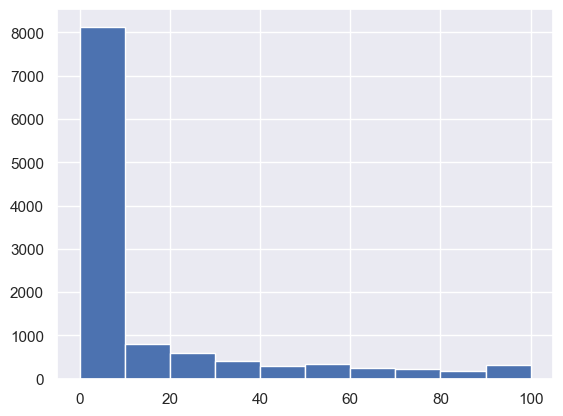

In [12]:
df.PanelReactiveAntibody_CPRA_CAN_average.hist();

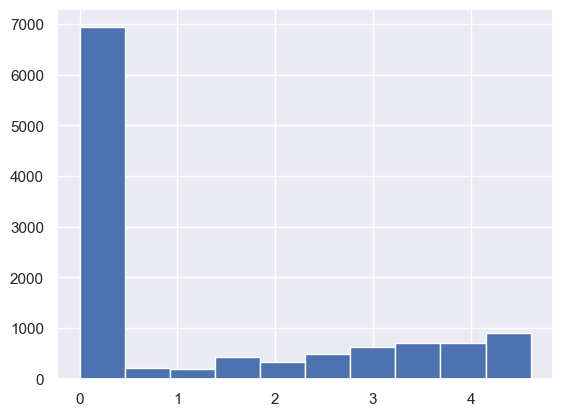

In [13]:
np.log(df.PanelReactiveAntibody_CPRA_CAN_average + 1).hist();

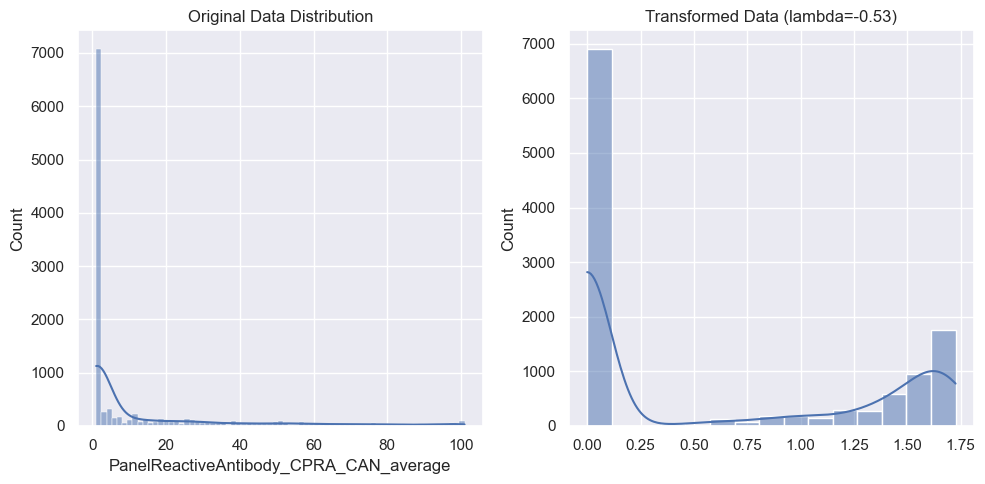

In [14]:
from scipy import stats

# series
series = df.PanelReactiveAntibody_CPRA_CAN_average.dropna()

# removing 
series = series + 1

# apply Box-Cox transformation
data, lambda_optimal = stats.boxcox(series)

# Plot the original data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(series, kde=True)
plt.title('Original Data Distribution')

# Plot the transformed data
plt.subplot(1, 2, 2)
sns.histplot(data, kde=True)
plt.title(f'Transformed Data (lambda={lambda_optimal:.2f})')

plt.tight_layout()
plt.show()

In [15]:
# initialize list
removeCol = list()

# add to list
removeCol.extend(['Peak_CPRA','Recent_CPRA','CombinedMeds','PrimaryPaymentSource_CAN', 'TransplantSurvivalDay_CAN'])

#### Hemodynamics

In [16]:
# add to list
Hemodynamics = df.columns[df.columns.str.contains('Hemodynamics')].to_list()

##### Impute all Hemodynamics with Mode

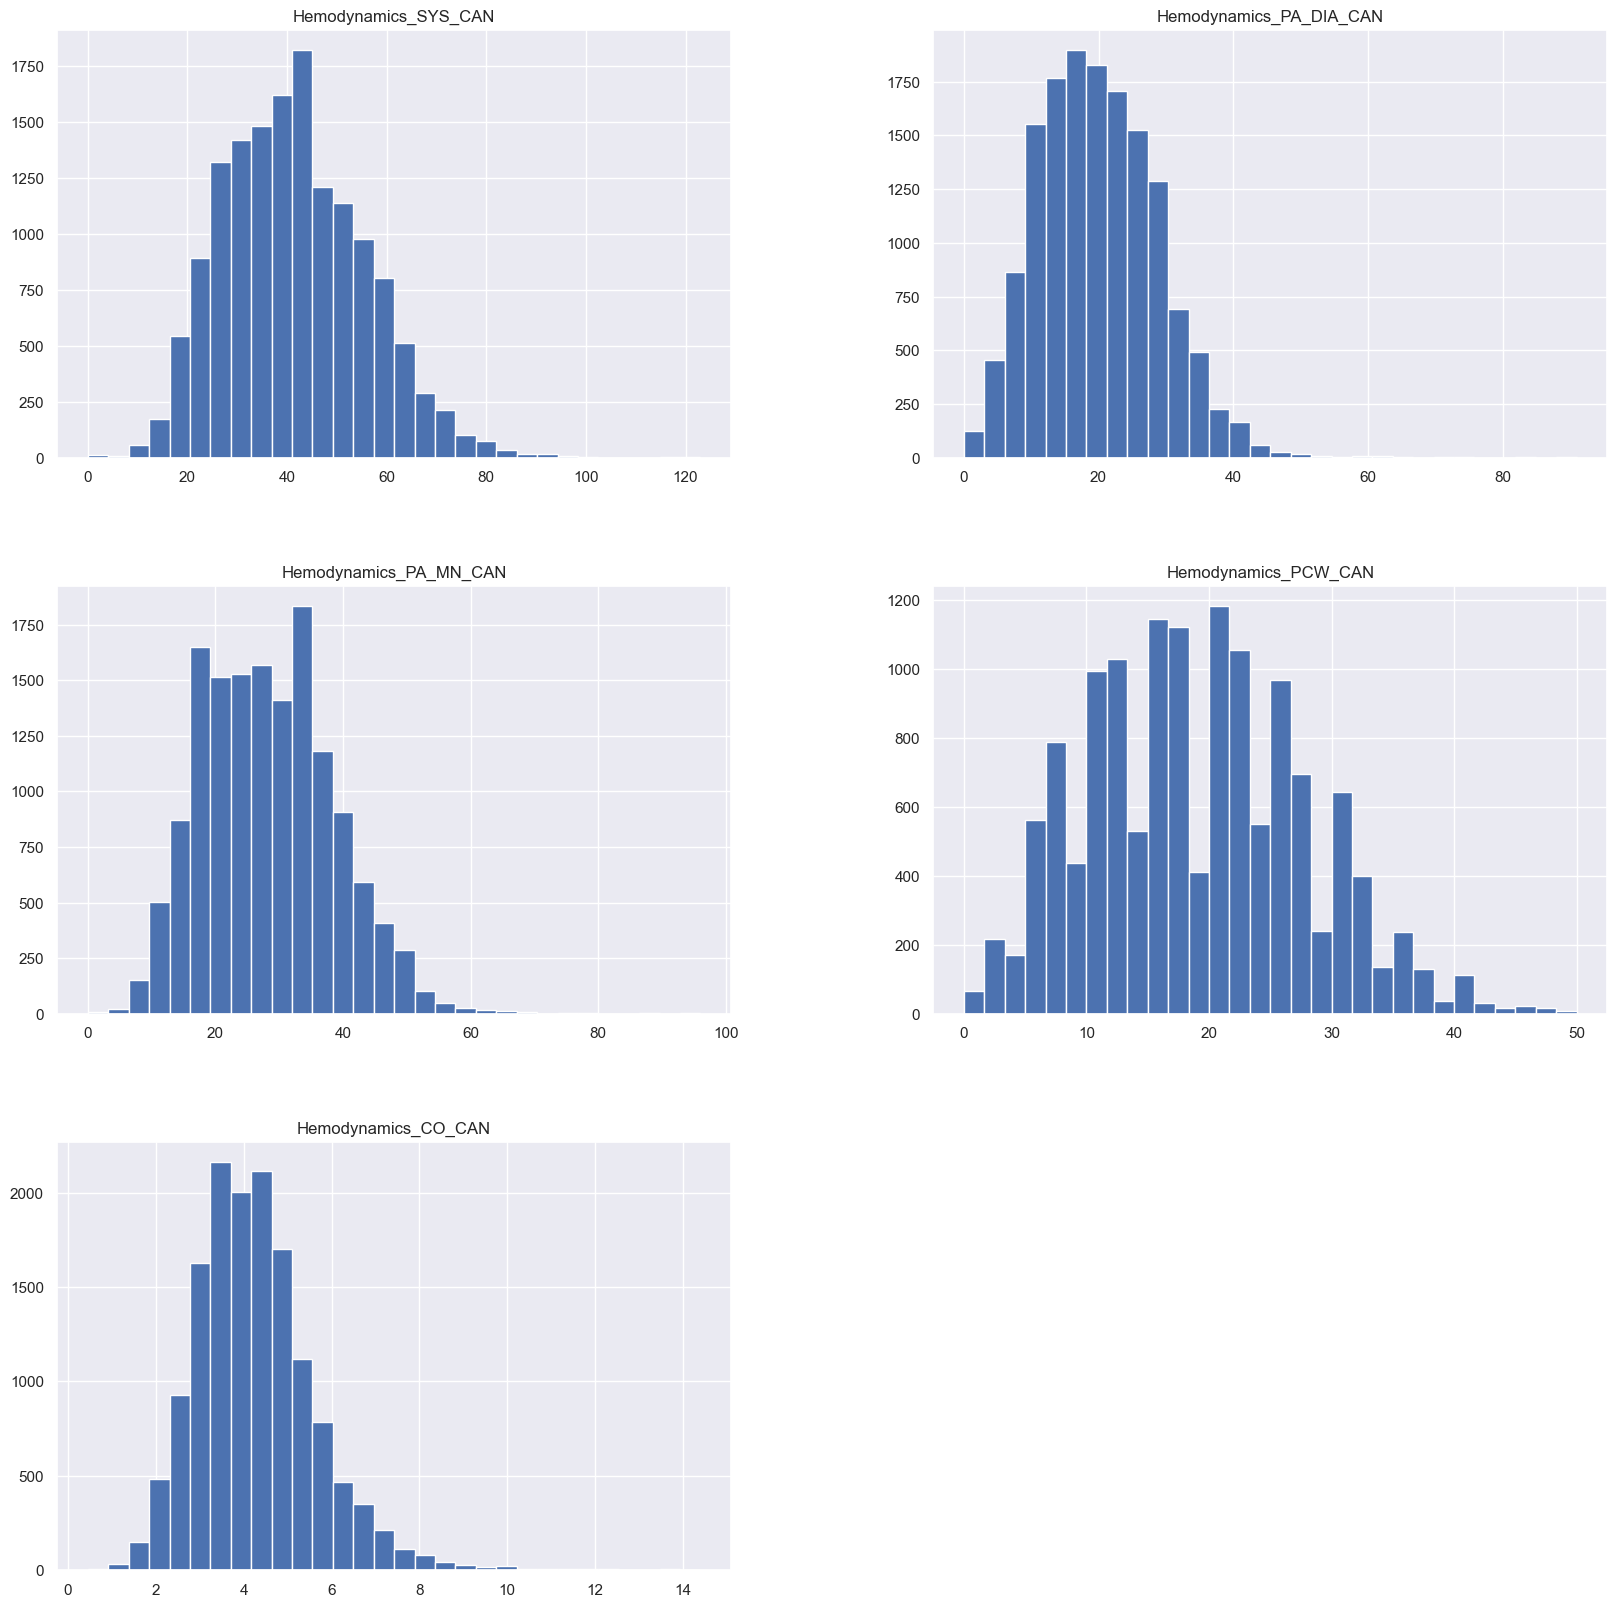

In [17]:
df[Hemodynamics].hist(figsize=(20,20), bins=30);

In [18]:
df[Hemodynamics].describe().T

,count,mean,std,min,25%,50%,75%,max
Hemodynamics_SYS_CAN,14730.0,41.365513,14.271882,0.00,31.00,40.0,51.0,123.0
Hemodynamics_PA_DIA_CAN,14720.0,20.239891,8.730424,0.00,14.00,20.0,26.0,91.0
Hemodynamics_PA_MN_CAN,14650.0,28.204324,10.254260,0.00,20.00,28.0,35.0,96.0
Hemodynamics_PCW_CAN,13949.0,18.801097,8.801873,0.00,12.00,18.0,25.0,50.0
Hemodynamics_CO_CAN,14441.0,4.258995,1.334258,0.45,3.33,4.1,5.0,14.4


##### Impute all Hemodynamics with Mean

In [19]:
# update NaN values with mean for the specified columns
for column in Hemodynamics:
    value = df[column].mean()  # get the mean of the column
    df[column] = df[column].fillna(value)  # replace NaNs with the mean value

In [20]:
df[Hemodynamics].describe().T

,count,mean,std,min,25%,50%,75%,max
Hemodynamics_SYS_CAN,15282.0,41.365513,14.011737,0.00,31.0,41.000000,50.00,123.0
Hemodynamics_PA_DIA_CAN,15282.0,20.239891,8.568378,0.00,14.0,20.000000,26.00,91.0
Hemodynamics_PA_MN_CAN,15282.0,28.204324,10.039970,0.00,21.0,28.000000,35.00,96.0
Hemodynamics_PCW_CAN,15282.0,18.801097,8.409209,0.00,13.0,18.801097,24.00,50.0
Hemodynamics_CO_CAN,15282.0,4.258995,1.297022,0.45,3.4,4.200000,4.93,14.4


#### Antigen

In [21]:
# add to list
Antigen = df.columns[df.columns.str.contains('Antigen') & ~df.columns.str.contains('SurfaceAntigen')].to_list()

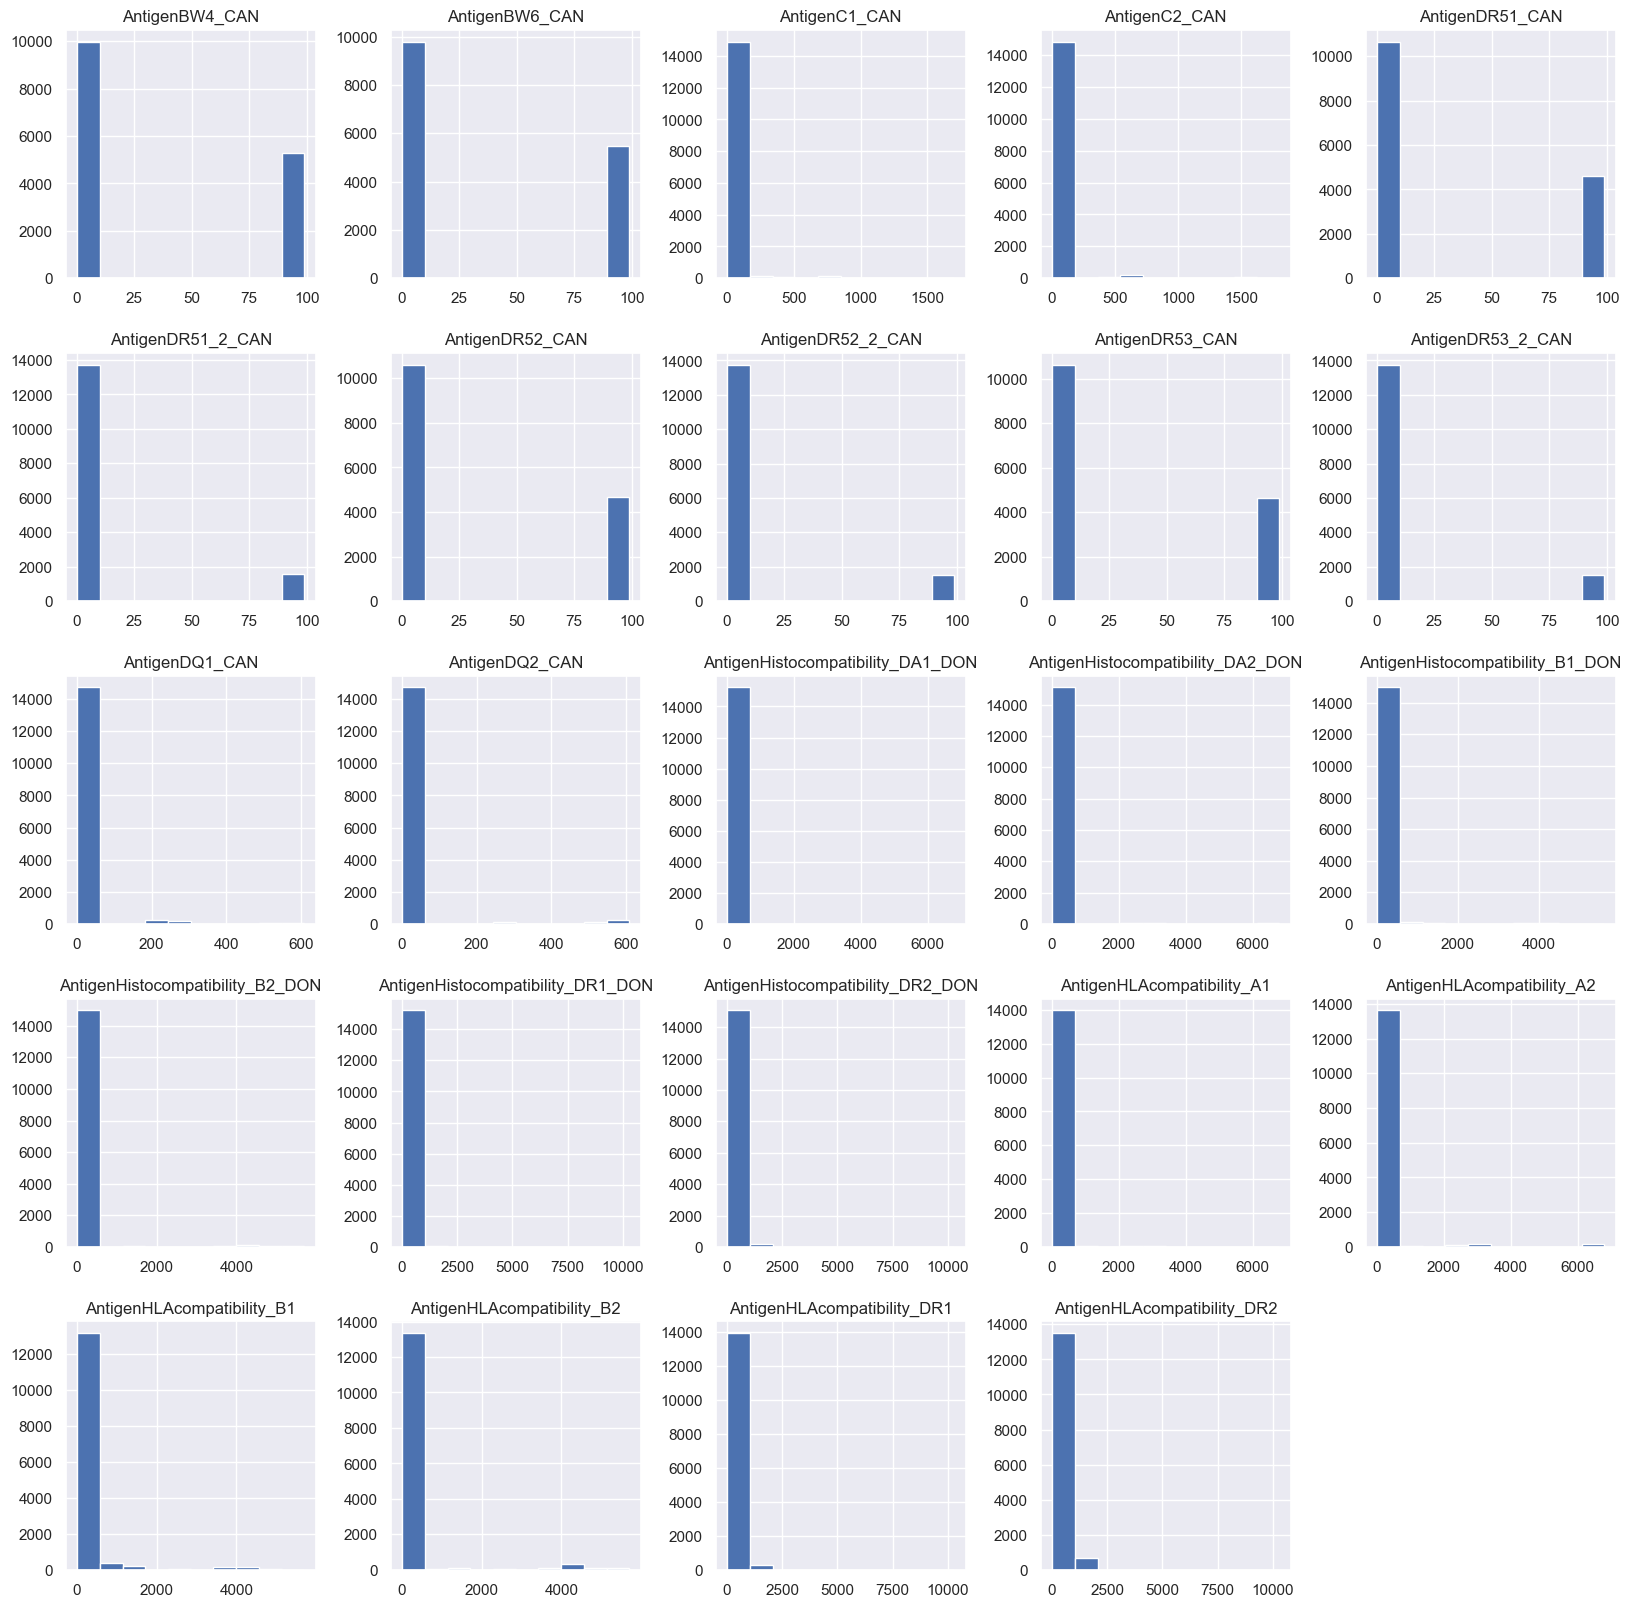

In [22]:
# plot
df[Antigen].hist(figsize=(20,20));

In [23]:
# disply features with NaNs
nanCol = [column for column in Antigen if df[column].isna().any()]

- `AntigenHLAcompatibility_A` indicates the presence of certain HLA-A antigens in the donor or recipient. These antigens are crucial for matching donors and recipients in organ transplantation, as they can influence the likelihood of transplant rejection or acceptance.
- `AntigenHLAcompatibility_B` indicates the presence of specific HLA-B antigens in the donor or recipient. These antigens are essential for matching donors and recipients in organ transplantation, impacting the likelihood of transplant rejection or acceptance.
- `AntigenHLAcompatibility_DR` indicates the presence of specific HLA-DR antigens in the donor or recipient. Matching HLA-DR antigens is essential in organ transplantation as it can significantly influence the success of the transplant.

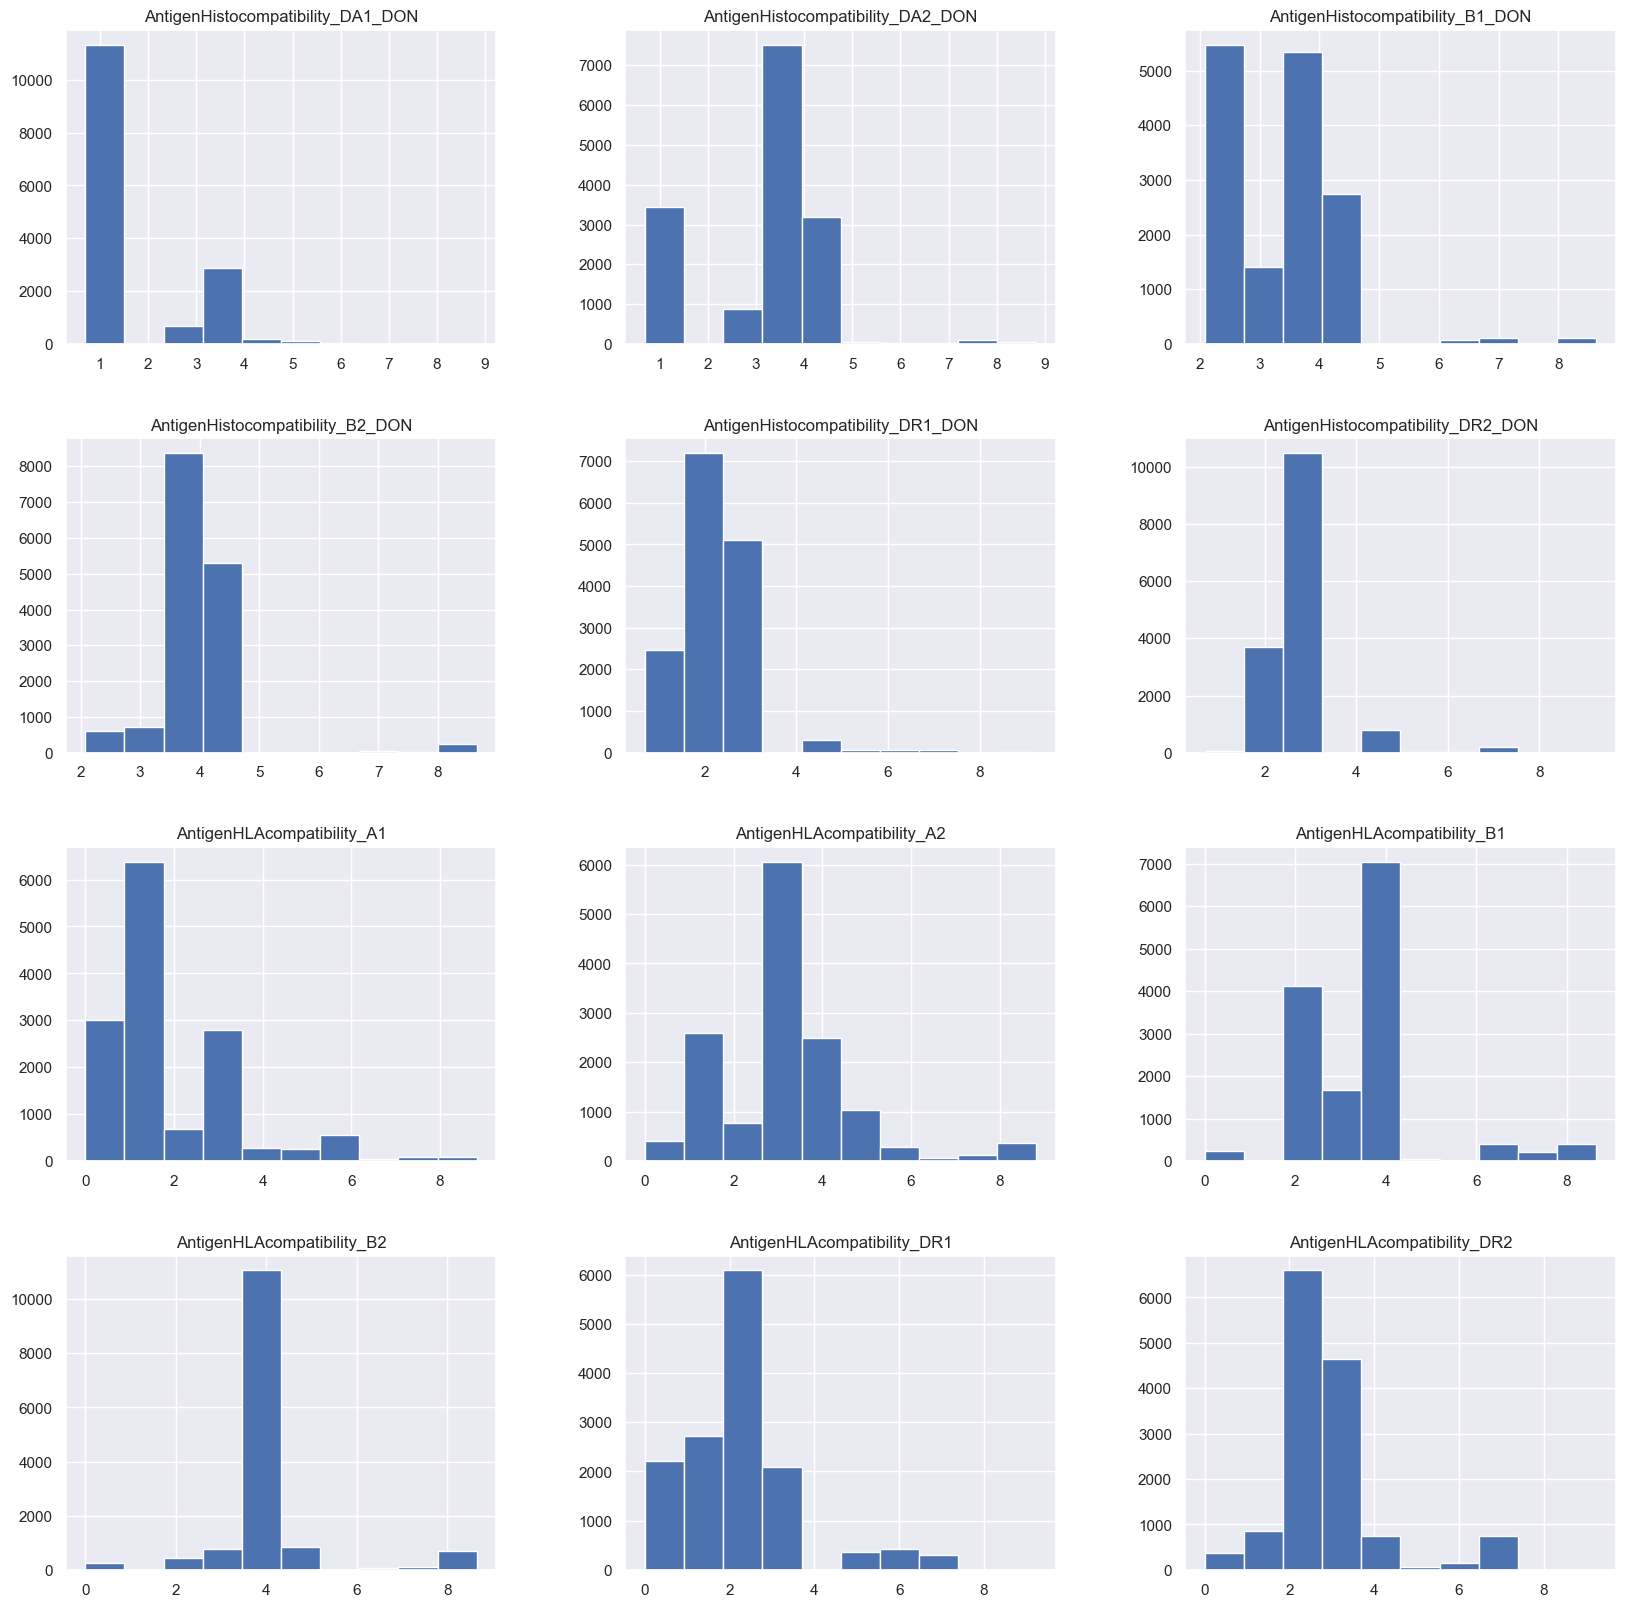

In [24]:
# plot
np.log(df[nanCol] + 1).hist(figsize=(20,20));

In [25]:
df[nanCol].describe().T

,count,mean,std,min,25%,50%,75%,max
AntigenHistocompatibility_DA1_DON,15280.0,18.741230,166.670555,1.0,2.0,2.0,11.0,6802.0
AntigenHistocompatibility_DA2_DON,15271.0,72.479602,426.548839,1.0,11.0,29.0,33.0,6802.0
AntigenHistocompatibility_B1_DON,15280.0,73.481741,362.512197,7.0,8.0,35.0,49.0,5603.0
AntigenHistocompatibility_B2_DON,15268.0,121.703367,551.090025,7.0,44.0,51.0,60.0,5703.0
AntigenHistocompatibility_DR1_DON,15279.0,26.153282,300.852568,1.0,4.0,7.0,13.0,10300.0
AntigenHistocompatibility_DR2_DON,15268.0,36.474194,209.372993,1.0,11.0,13.0,15.0,10300.0
AntigenHLAcompatibility_A1,14196.0,61.425049,375.992196,0.0,2.0,2.0,23.0,6802.0
AntigenHLAcompatibility_A2,14196.0,184.838898,824.584375,0.0,11.0,30.0,68.0,6802.0
AntigenHLAcompatibility_B1,14196.0,184.401240,684.960769,0.0,8.0,35.0,53.0,5703.0
AntigenHLAcompatibility_B2,14196.0,277.719287,967.566310,0.0,44.0,52.0,61.0,5703.0


In [26]:
# add to list
removeCol.extend(df.columns[df.columns.str.contains('AntigenHLAcompatibility')].to_list())

#### Lung PO2
- Lung PO2 (Partial Pressure of Oxygen) is a measure of the pressure exerted by oxygen in the lungs. It is an important indicator of how well oxygen is being transferred from the air in the lungs to the blood. The value of PO2 is typically measured in millimeters of mercury (mmHg) and provides insight into the efficiency of the respiratory system. In clinical and transplant contexts, particularly with donors, it helps assess the oxygenation status of the donor’s lungs, which is critical when evaluating organs for transplantation.

In [27]:
# get all Hemodynamics features
LungPO2 = df.columns[df.columns.str.contains('LungPO2')].to_list()

# describe
df[LungPO2].describe().T

,count,mean,std,min,25%,50%,75%,max
LungPO2_DON,15088.0,283.522786,160.586536,12.0,130.0,267.0,429.475,698.0
LungPO2_FIO2_DON,15033.0,82.633140,25.205573,6.0,60.0,100.0,100.000,100.0


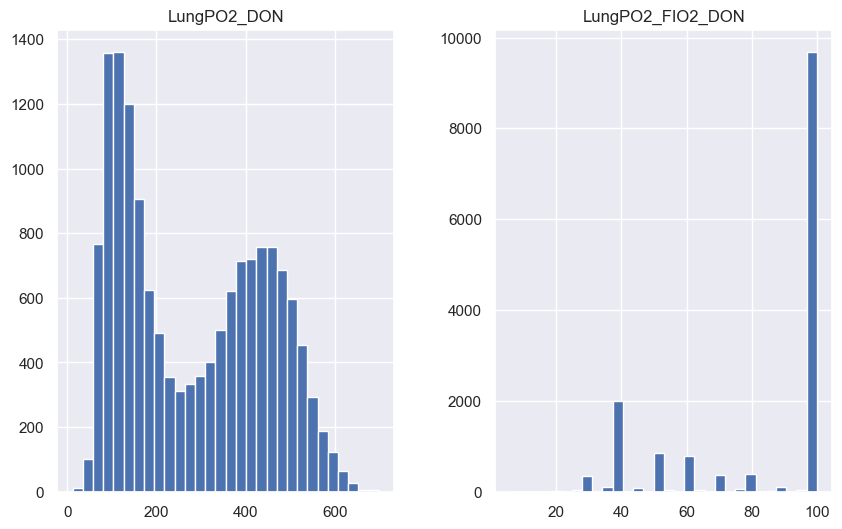

In [28]:
df[LungPO2].hist(figsize=(10,6), bins=30);

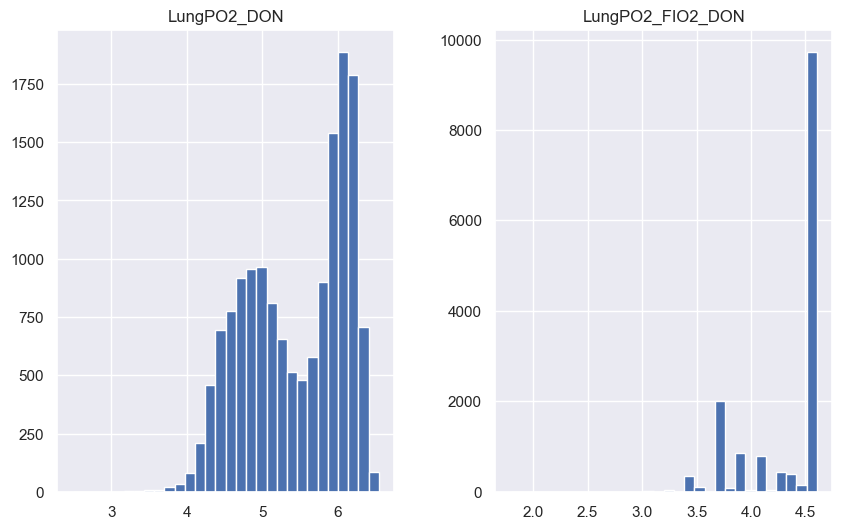

In [29]:
# log transform
np.log(df[LungPO2]).hist(figsize=(10,6), bins=30);

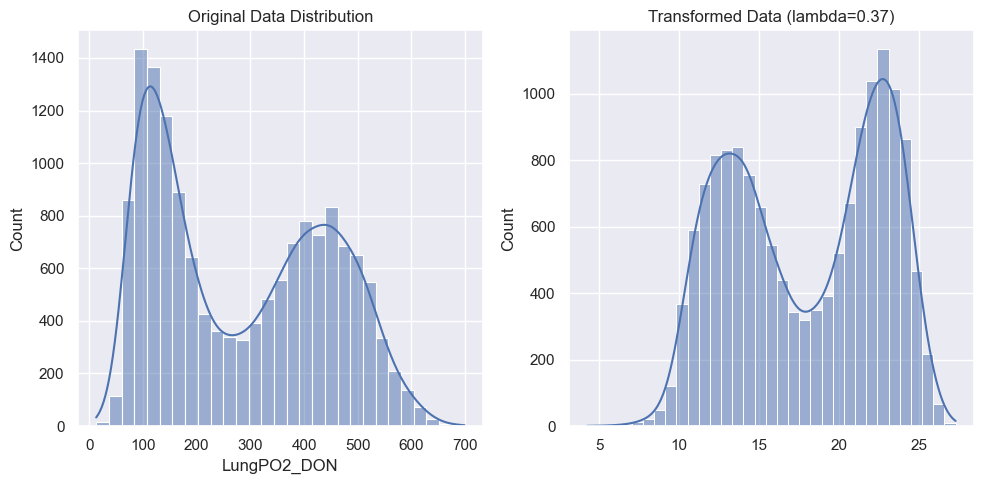

In [30]:
# series
series = df.LungPO2_DON.dropna()

# removing 
series = series + 1

# apply Box-Cox transformation
data, lambda_optimal = stats.boxcox(series)

# Plot the original data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(series, kde=True)
plt.title('Original Data Distribution')

# Plot the transformed data
plt.subplot(1, 2, 2)
sns.histplot(data, kde=True)
plt.title(f'Transformed Data (lambda={lambda_optimal:.2f})')

plt.tight_layout()
plt.show()

#### Bilirubin
- Bilirubin is a key marker for assessing liver function and diagnosing various medical conditions. Monitoring bilirubin levels, both total and broken down into unconjugated and conjugated forms, provides critical insights into a patient's health status, particularly concerning liver and red blood cell health.

In [31]:
# add to list
Bilirubin = df.columns[df.columns.str.contains('Bilirubin')].to_list()

##### Box-Cox transformation

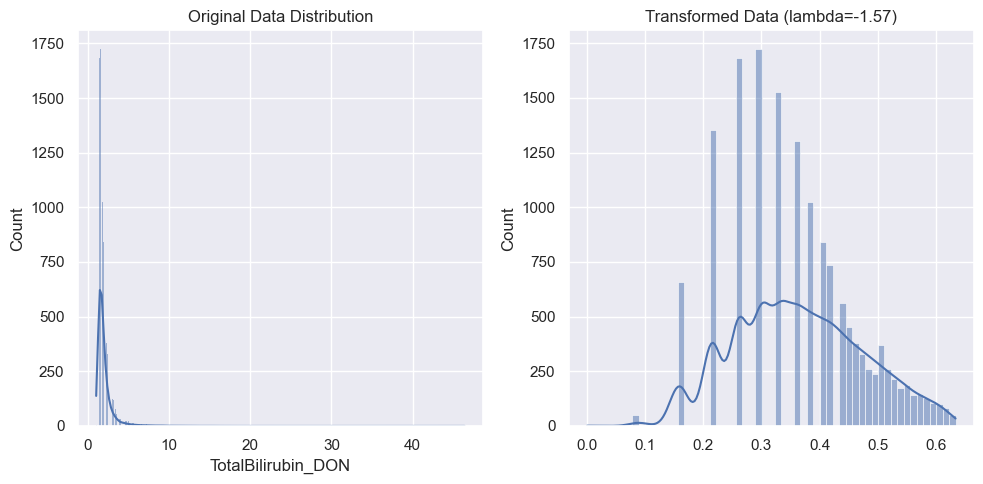

In [32]:
# series
series = df.TotalBilirubin_DON.dropna()

# removing 
series = series + 1

# apply Box-Cox transformation
data, lambda_optimal = stats.boxcox(series)

# Plot the original data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(series, kde=True)
plt.title('Original Data Distribution')

# Plot the transformed data
plt.subplot(1, 2, 2)
sns.histplot(data, kde=True)
plt.title(f'Transformed Data (lambda={lambda_optimal:.2f})')

plt.tight_layout()
plt.show()

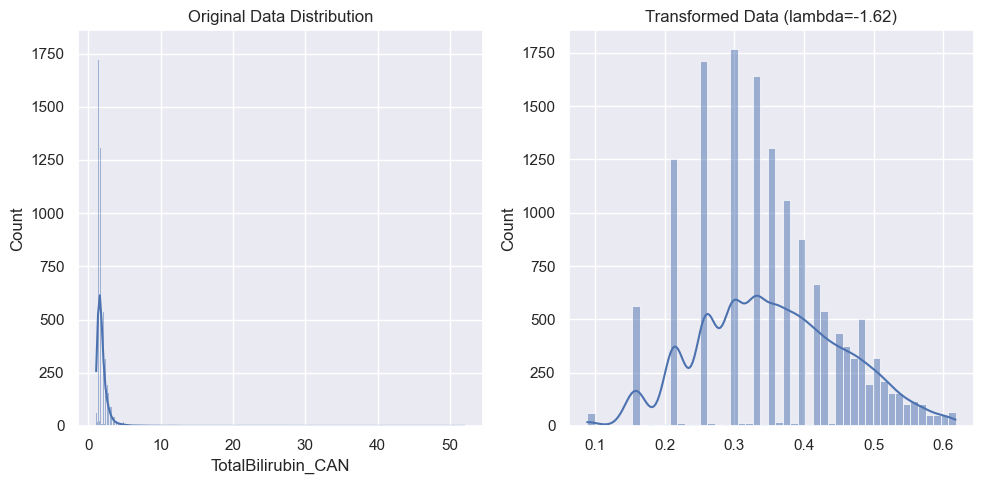

In [33]:
# series
series = df.TotalBilirubin_CAN.dropna()

# removing 
series = series + 1

# apply Box-Cox transformation
data, lambda_optimal = stats.boxcox(series)

# Plot the original data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(series, kde=True)
plt.title('Original Data Distribution')

# Plot the transformed data
plt.subplot(1, 2, 2)
sns.histplot(data, kde=True)
plt.title(f'Transformed Data (lambda={lambda_optimal:.2f})')

plt.tight_layout()
plt.show()

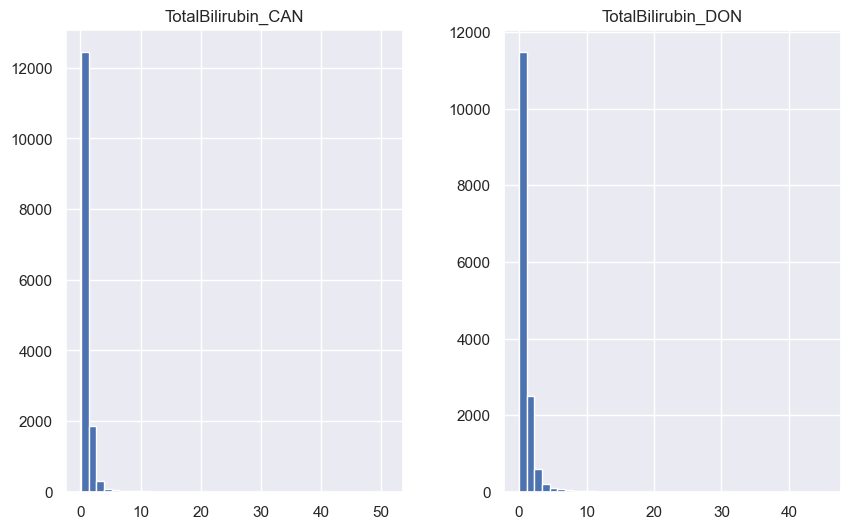

In [34]:
# plot
df[Bilirubin].hist(figsize=(10,6), bins=40);

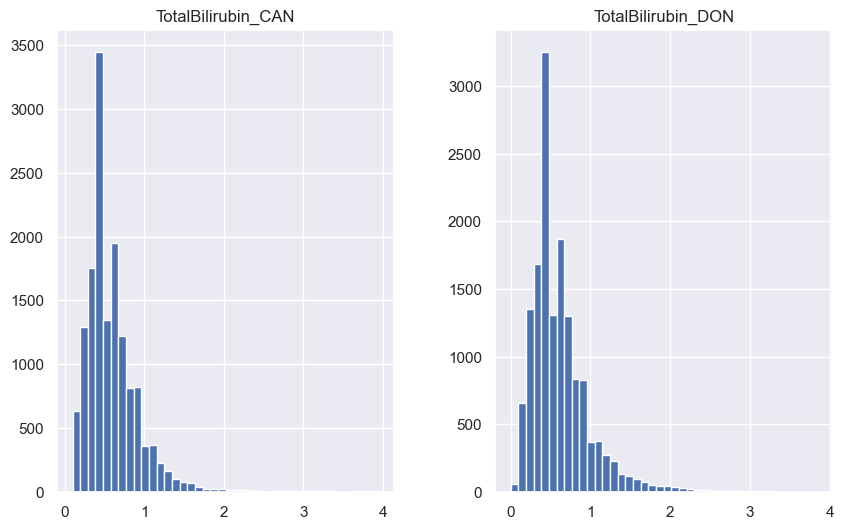

In [35]:
# plot
np.log(df[Bilirubin] + 1).hist(figsize=(10,6), bins=40);

##### Impute all Bilirubin with Median

In [36]:
df[Bilirubin].describe().T

,count,mean,std,min,25%,50%,75%,max
TotalBilirubin_CAN,14855.0,0.994547,1.813952,0.1,0.5,0.7,1.1,51.0
TotalBilirubin_DON,15094.0,1.047463,1.536677,0.0,0.5,0.7,1.1,45.4


In [37]:
# update NaN values with median for the specified columns
for column in Bilirubin:
    value = df[column].median()  # get the median of the column
    df[column] = df[column].fillna(value)  # replace NaNs with the median value

In [38]:
df[Bilirubin].describe().T

,count,mean,std,min,25%,50%,75%,max
TotalBilirubin_CAN,15282.0,0.986317,1.789088,0.1,0.5,0.7,1.0,51.0
TotalBilirubin_DON,15282.0,1.043189,1.527675,0.0,0.5,0.7,1.1,45.4


##### Transform Feature to LOG

In [39]:
df[Bilirubin] = np.log(df[Bilirubin] + 1)

#### RecoveryTransplant_difference
- After removal for transplantation, a heart can typically remain viable for about 4 to 6 hours

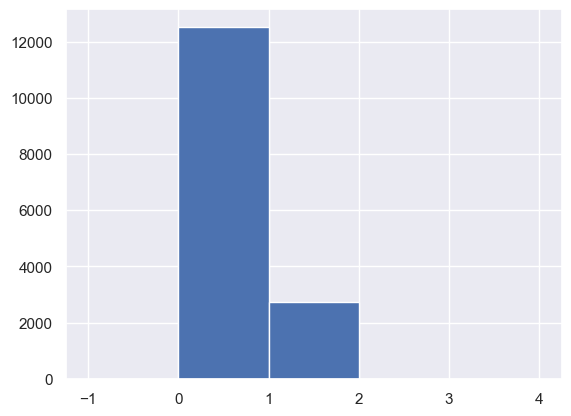

In [40]:
df.RecoveryTransplant_difference.hist(bins=5);

##### Remove

In [41]:
# add toi list
removeCol.extend(['RecoveryTransplant_difference'])

#### BloodUreaNitrogenLevel_DON

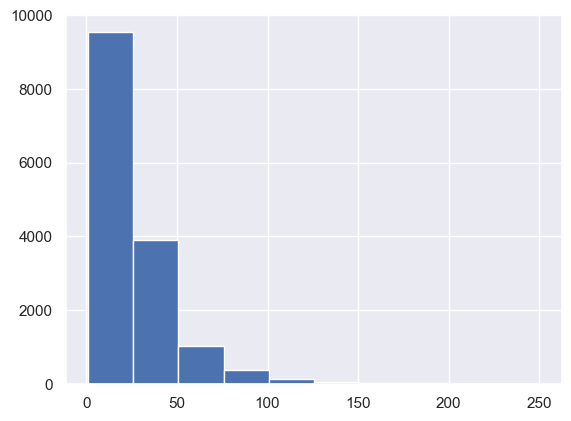

In [42]:
df.BloodUreaNitrogenLevel_DON.hist();

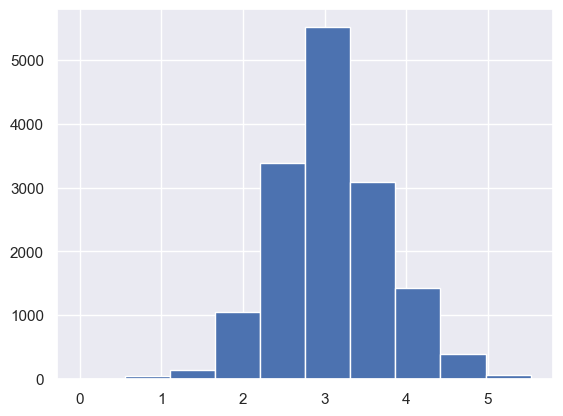

In [43]:
np.log(df.BloodUreaNitrogenLevel_DON).hist();

##### Impute all BloodUreaNitrogenLevel_DON Mean

In [44]:
df['BloodUreaNitrogenLevel_DON'].describe().T

count    15095.000000
mean        27.344747
std         22.139277
min          1.000000
25%         14.000000
50%         21.000000
75%         32.000000
max        250.000000
Name: BloodUreaNitrogenLevel_DON, dtype: float64

In [45]:
# update NaN values with mean for BloodUreaNitrogenLevel_DON
df['BloodUreaNitrogenLevel_DON'] = df['BloodUreaNitrogenLevel_DON'].fillna(df.BloodUreaNitrogenLevel_DON.mean())  # replace NaNs with the mean value

In [46]:
df['BloodUreaNitrogenLevel_DON'].describe().T

count    15282.000000
mean        27.344747
std         22.003397
min          1.000000
25%         14.000000
50%         21.000000
75%         32.000000
max        250.000000
Name: BloodUreaNitrogenLevel_DON, dtype: float64

##### Transform Feature to LOG

In [47]:
df['BloodUreaNitrogenLevel_DON'] = np.log(df['BloodUreaNitrogenLevel_DON'] + 1)

#### Level_SGOT
- `Level_SGOT_AST` and `Level_SGOT_ALT` are important for assessing liver health, they have different functions, locations, and clinical implications. ALT is more specific to liver damage, while AST can indicate damage in other tissues as well.

In [48]:
# add to list
LevelSGOT = df.columns[df.columns.str.contains('Level_SGOT')].to_list()

# describe
df[LevelSGOT].describe().T

,count,mean,std,min,25%,50%,75%,max
Level_SGOT_AST_DON,15094.0,100.639857,299.447130,0.4,25.0,44.0,88.0,10196.0
Level_SGOT_ALT_DON,15094.0,121.469723,479.528295,3.0,24.0,43.0,88.0,44117.0


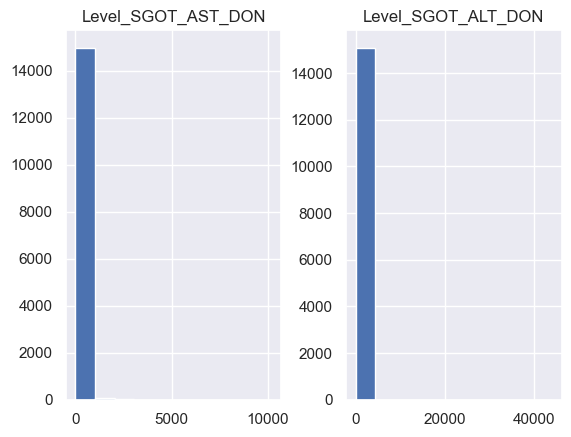

In [49]:
df[LevelSGOT].hist();

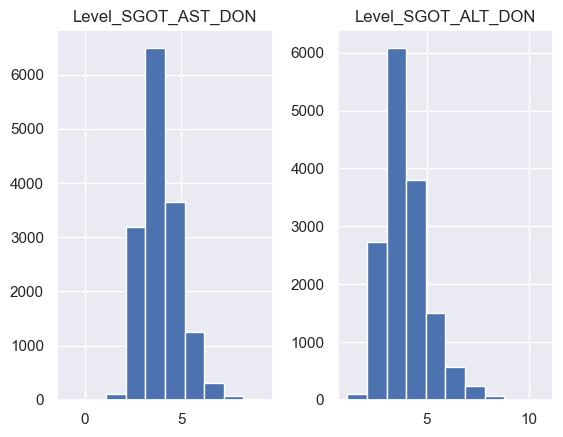

In [50]:
np.log(df[LevelSGOT]).hist();

In [51]:
df[LevelSGOT].describe().T

,count,mean,std,min,25%,50%,75%,max
Level_SGOT_AST_DON,15094.0,100.639857,299.447130,0.4,25.0,44.0,88.0,10196.0
Level_SGOT_ALT_DON,15094.0,121.469723,479.528295,3.0,24.0,43.0,88.0,44117.0


##### Impute all Level_SGOT Median

In [52]:
# update NaN values with median for the specified columns
for column in LevelSGOT:
    value = df[column].median()  # get the median of the column
    df[column] = df[column].fillna(value)  # replace NaNs with the median value

In [53]:
df[LevelSGOT].describe().T

,count,mean,std,min,25%,50%,75%,max
Level_SGOT_AST_DON,15282.0,99.943070,297.664890,0.4,25.0,44.0,87.0,10196.0
Level_SGOT_ALT_DON,15282.0,120.504384,476.647876,3.0,24.0,43.0,87.0,44117.0


##### Transform Feature to LOG

In [54]:
df[LevelSGOT] = np.log(df[LevelSGOT])

#### Hematocrit_DON

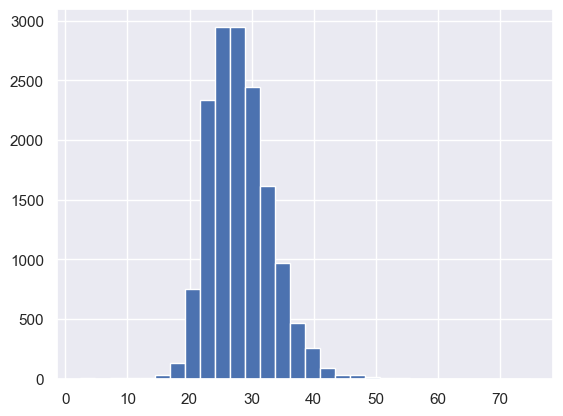

In [55]:
df.Hematocrit_DON.hist(bins=30);

In [56]:
df['Hematocrit_DON'].describe().T

count    15095.000000
mean        28.098052
std          4.935037
min          2.300000
25%         24.700000
50%         27.500000
75%         31.000000
max         75.000000
Name: Hematocrit_DON, dtype: float64

##### Impute all Level_SGOT Median

In [57]:
# update NaN values with median for the specified columns
df['Hematocrit_DON'] = df['Hematocrit_DON'].fillna(df['Hematocrit_DON'].median())  # replace NaNs with the median value

In [58]:
df['Hematocrit_DON'].describe().T

count    15282.000000
mean        28.090734
std          4.905189
min          2.300000
25%         24.700000
50%         27.500000
75%         31.000000
max         75.000000
Name: Hematocrit_DON, dtype: float64

#### BloodUreaNitrogenLevel_DON

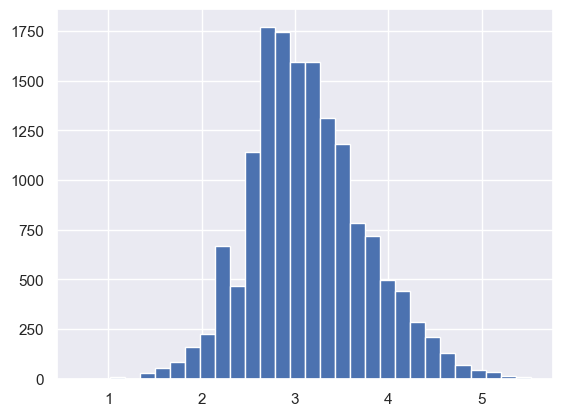

In [59]:
df.BloodUreaNitrogenLevel_DON.hist(bins=30);

In [60]:
df.BloodUreaNitrogenLevel_DON.describe()

count    15282.000000
mean         3.138219
std          0.616560
min          0.693147
25%          2.708050
50%          3.091042
75%          3.496508
max          5.525453
Name: BloodUreaNitrogenLevel_DON, dtype: float64

##### Impute all BloodUreaNitrogenLevel_DON Mean

In [61]:
# update NaN values with median for the specified columns
df['BloodUreaNitrogenLevel_DON'] = df['BloodUreaNitrogenLevel_DON'].fillna(df['BloodUreaNitrogenLevel_DON'].mean())  # replace NaNs with the mean value

In [62]:
df.BloodUreaNitrogenLevel_DON.describe()

count    15282.000000
mean         3.138219
std          0.616560
min          0.693147
25%          2.708050
50%          3.091042
75%          3.496508
max          5.525453
Name: BloodUreaNitrogenLevel_DON, dtype: float64

##### Remove
- Redunant Informtion: Organ Recovery Date minus Transplant date

In [63]:
# add to list
removeCol.extend(['RecoveryTransplant_difference'])

#### PrimaryPaymentSource_CAN

In [64]:
df.PrimaryPaymentSource_CAN.value_counts()

PrimaryPaymentSource_CAN
Private insurance                                                7577
Public insurance - Medicare FFS (Fee for Service)                2542
Public insurance - Medicare & Choice                             2247
Public insurance - Medicaid                                      2141
Public insurance - Department of VA                               313
Public insurance - Other government                               275
Foreign Government Specify                                         53
Self                                                               27
Free Care                                                          14
Pending                                                            10
Public insurance - CHIP (Children's Health Insurance Program)       8
Donation                                                            3
Name: count, dtype: int64

In [65]:
# add to list
removeCol.extend(['PrimaryPaymentSource_CAN'])

In [67]:
# remove & house keeping
df, df_dict, df_remove, df_unknown, df_label, df_new, df_can, df_don, df_both = removeHouseKeeping(df, removeCol, df_dict, df_remove, df_unknown, df_label, df_new, df_can, df_don, df_both)

Data Dictionary Updated.
Remove row(s) from df_remove DataFrame.
Remove row(s) from df_unknown DataFrame.
Remove row(s) from df_label DataFrame.
Remove row(s) from df_new DataFrame.
Remove row(s) from df_can DataFrame.
Remove row(s) from df_don DataFrame.
Remove row(s) from df_both DataFrame.

Removed Features:['Peak_CPRA', 'Recent_CPRA', 'CombinedMeds', 'PrimaryPaymentSource_CAN', 'TransplantSurvivalDay_CAN', 'AntigenHLAcompatibility_A1', 'AntigenHLAcompatibility_A2', 'AntigenHLAcompatibility_B1', 'AntigenHLAcompatibility_B2', 'AntigenHLAcompatibility_DR1', 'AntigenHLAcompatibility_DR2', 'RecoveryTransplant_difference', 'RecoveryTransplant_difference', 'PrimaryPaymentSource_CAN']

Total rows before: 15,282 & columns: 218
Total rows after: 15,282 & columns: 206


In [68]:
# display NaNs
DFNaN = percentageNull(df)

# display
DFNaN

,percentage,NaNCount
PanelReactiveAntibody_CPRA_CAN_average,24.479780,3741
LungPO2_FIO2_DON,1.629368,249
LungPO2_DON,1.269467,194
PrimaryDiagnosisCode_CAN,0.477686,73
AntigenHistocompatibility_DR2_DON,0.091611,14
AntigenHistocompatibility_B2_DON,0.091611,14
AntigenHistocompatibility_DA2_DON,0.071980,11
AntigenHistocompatibility_DR1_DON,0.019631,3
AntigenHistocompatibility_B1_DON,0.013087,2
AntigenHistocompatibility_DA1_DON,0.013087,2


##### Hemodynamics_CO_After_CAN_average

In [9]:
# get indices
rowIdx = df[
    df.Hemodynamics_CO_After_CAN_average.isna() & (~df.Hemodynamics_CO_CAN.isna() | ~df.HemodynamicsAfter_CO_CAN.isna())].index

# column indices or can find them using the column names
colIdx = [df.columns.get_loc(col) for col in ['Hemodynamics_CO_CAN', 'HemodynamicsAfter_CO_CAN', 'Hemodynamics_CO_After_CAN_average']]

# display
df.iloc[rowIdx, colIdx].sample(5)

,Hemodynamics_CO_CAN,HemodynamicsAfter_CO_CAN,Hemodynamics_CO_After_CAN_average
12188,NaN,7.64,NaN
8481,NaN,2.30,NaN
14997,5.75,NaN,NaN
7192,NaN,4.50,NaN
4591,NaN,7.49,NaN


In [10]:
# update Hemodynamics_CO_After_CAN_average with non-NaN values from Hemodynamics_CO_CAN and HemodynamicsAfter_CO_CAN
df['Hemodynamics_CO_After_CAN_average'] = df['Hemodynamics_CO_After_CAN_average'].fillna(df['Hemodynamics_CO_CAN'].combine_first(df['HemodynamicsAfter_CO_CAN']))

# display
df.iloc[rowIdx, colIdx].sample(5)

,Hemodynamics_CO_CAN,HemodynamicsAfter_CO_CAN,Hemodynamics_CO_After_CAN_average
14573,4.60,NaN,4.60
9585,NaN,4.84,4.84
1296,NaN,2.43,2.43
14088,4.93,NaN,4.93
15100,3.00,NaN,3.00


##### Hemodynamics_PA_DIA_After_CAN_average

In [11]:
# get indices
rowIdx = df[
    df.Hemodynamics_PA_DIA_After_CAN_average.isna() & (~df.Hemodynamics_PA_DIA_CAN.isna() | ~df.HemodynamicsAfter_PA_DIA_CAN.isna())].index

# column indices or can find them using the column names
colIdx = [df.columns.get_loc(col) for col in ['Hemodynamics_PA_DIA_CAN', 'HemodynamicsAfter_PA_DIA_CAN', 'Hemodynamics_PA_DIA_After_CAN_average']]

# display
df.iloc[rowIdx, colIdx].sample(5)

,Hemodynamics_PA_DIA_CAN,HemodynamicsAfter_PA_DIA_CAN,Hemodynamics_PA_DIA_After_CAN_average
14618,20.0,NaN,NaN
8260,18.0,NaN,NaN
4578,NaN,16.0,NaN
15177,2.0,NaN,NaN
14934,24.0,NaN,NaN


In [12]:
# update Hemodynamics_PA_DIA_After_CAN_average with non-NaN values from Hemodynamics_PA_DIA_CAN and HemodynamicsAfter_PA_DIA_CAN
df['Hemodynamics_PA_DIA_After_CAN_average'] = df['Hemodynamics_PA_DIA_After_CAN_average'].fillna(df['Hemodynamics_PA_DIA_CAN'].combine_first(df['HemodynamicsAfter_PA_DIA_CAN']))

# display
df.iloc[rowIdx, colIdx].sample(5)

,Hemodynamics_PA_DIA_CAN,HemodynamicsAfter_PA_DIA_CAN,Hemodynamics_PA_DIA_After_CAN_average
7266,NaN,19.0,19.0
4960,NaN,29.0,29.0
14007,NaN,9.0,9.0
14771,29.0,NaN,29.0
9404,29.0,NaN,29.0


##### Hemodynamics_PA_MN_After_CAN_average

In [13]:
# get indices
rowIdx = df[
    df.Hemodynamics_PA_MN_After_CAN_average.isna() & (~df.Hemodynamics_PA_DIA_CAN.isna() | ~df.HemodynamicsAfter_PA_DIA_CAN.isna())].index

# column indices or can find them using the column names
colIdx = [df.columns.get_loc(col) for col in ['Hemodynamics_PA_MN_CAN', 'HemodynamicsAfter_PA_MN_CAN', 'Hemodynamics_PA_MN_After_CAN_average']]

# display
df.iloc[rowIdx, colIdx].sample(5)

,Hemodynamics_PA_MN_CAN,HemodynamicsAfter_PA_MN_CAN,Hemodynamics_PA_MN_After_CAN_average
9004,45.0,NaN,NaN
15122,27.0,NaN,NaN
11567,14.0,NaN,NaN
15135,18.0,NaN,NaN
12246,32.0,NaN,NaN


In [14]:
# update Hemodynamics_PA_MN_After_CAN_average with non-NaN values from Hemodynamics_PA_MN_CAN and HemodynamicsAfter_PA_MN_CAN
df['Hemodynamics_PA_MN_After_CAN_average'] = df['Hemodynamics_PA_MN_After_CAN_average'].fillna(df['Hemodynamics_PA_MN_CAN'].combine_first(df['HemodynamicsAfter_PA_MN_CAN']))

# display
df.iloc[rowIdx, colIdx].sample(5)

,Hemodynamics_PA_MN_CAN,HemodynamicsAfter_PA_MN_CAN,Hemodynamics_PA_MN_After_CAN_average
2817,35.0,NaN,35.0
4013,27.0,NaN,27.0
11671,41.0,NaN,41.0
14974,21.0,NaN,21.0
4035,20.0,NaN,20.0


##### Hemodynamics_PCW_After_CAN_average

In [15]:
# get indices
rowIdx = df[
    df.Hemodynamics_PCW_After_CAN_average.isna() & (~df.Hemodynamics_PCW_CAN.isna() | ~df.HemodynamicsAfter_PCW_CAN.isna())].index

# column indices or can find them using the column names
colIdx = [df.columns.get_loc(col) for col in ['Hemodynamics_PCW_CAN', 'HemodynamicsAfter_PCW_CAN', 'Hemodynamics_PCW_After_CAN_average']]

# display
df.iloc[rowIdx, colIdx].sample(5)

,Hemodynamics_PCW_CAN,HemodynamicsAfter_PCW_CAN,Hemodynamics_PCW_After_CAN_average
13595,NaN,32.0,NaN
11146,29.0,NaN,NaN
15134,11.0,NaN,NaN
15246,30.0,NaN,NaN
14512,21.0,NaN,NaN


In [16]:
# update Hemodynamics_PCW_After_CAN_average with non-NaN values from Hemodynamics_PCW_CAN and HemodynamicsAfter_PCW_CAN
df['Hemodynamics_PCW_After_CAN_average'] = df['Hemodynamics_PCW_After_CAN_average'].fillna(df['Hemodynamics_PCW_CAN'].combine_first(df['HemodynamicsAfter_PCW_CAN']))

# display
df.iloc[rowIdx, colIdx].sample(5)

,Hemodynamics_PCW_CAN,HemodynamicsAfter_PCW_CAN,Hemodynamics_PCW_After_CAN_average
15140,13.0,NaN,13.0
2708,20.0,NaN,20.0
7312,NaN,8.0,8.0
10226,16.0,NaN,16.0
8667,7.0,NaN,7.0


##### Hemodynamics_SYS_After_CAN_average

In [17]:
# get indices
rowIdx = df[
    df.Hemodynamics_SYS_After_CAN_average.isna() & (~df.Hemodynamics_PCW_CAN.isna() | ~df.HemodynamicsAfter_PCW_CAN.isna())].index

# column indices or can find them using the column names
colIdx = [df.columns.get_loc(col) for col in ['Hemodynamics_SYS_CAN', 'HemodynamicsAfter_SYS_CAN', 'Hemodynamics_SYS_After_CAN_average']]

# display
df.iloc[rowIdx, colIdx].sample(5)

,Hemodynamics_SYS_CAN,HemodynamicsAfter_SYS_CAN,Hemodynamics_SYS_After_CAN_average
10124,NaN,23.0,NaN
8074,NaN,38.0,NaN
15241,42.0,NaN,NaN
15030,45.0,NaN,NaN
15082,49.0,NaN,NaN


In [18]:
# update Hemodynamics_SYS_After_CAN_average with non-NaN values from Hemodynamics_SYS_CAN and HemodynamicsAfter_SYS_CAN
df['Hemodynamics_SYS_After_CAN_average'] = df['Hemodynamics_SYS_After_CAN_average'].fillna(df['Hemodynamics_SYS_CAN'].combine_first(df['HemodynamicsAfter_SYS_CAN']))

# display
df.iloc[rowIdx, colIdx].sample(5)

,Hemodynamics_SYS_CAN,HemodynamicsAfter_SYS_CAN,Hemodynamics_SYS_After_CAN_average
15113,40.0,NaN,40.0
8733,30.0,NaN,30.0
15115,33.0,NaN,33.0
4475,NaN,NaN,NaN
12323,45.0,NaN,45.0


- CPRA Measurement: Calculated based on the recipient's HLA (Human Leukocyte Antigen) antibodies, which are identified through laboratory testing. The cPRA score helps determine how many donors are compatible with a given recipient.
Interpretation:
    - cPRA = 0%: The recipient is less sensitized and likely has a wider range of compatible donor options.
    - cPRA ≥ 80%: The recipient has developed antibodies against many HLA antigens, reducing compatibility with most donors.
    - cPRA = 100%: Indicates extreme sensitization, with antibodies against nearly all potential donor HLA antigens, making transplantation particularly difficult.

In [20]:
df[['Peak_CPRA','Recent_CPRA', 'PanelReactiveAntibody_CPRA_CAN_average']].describe().T

,count,mean,std,min,25%,50%,75%,max
Peak_CPRA,11520.0,15.459375,27.056899,0.0,0.0,0.0,21.0,100.0
Recent_CPRA,11535.0,11.444733,23.751543,0.0,0.0,0.0,7.0,100.0
PanelReactiveAntibody_CPRA_CAN_average,11541.0,13.450914,24.739557,0.0,0.0,0.0,16.0,100.0


In [21]:
df[['Peak_CPRA','Recent_CPRA','PanelReactiveAntibody_CPRA_CAN_average']].corr()

,Peak_CPRA,Recent_CPRA,PanelReactiveAntibody_CPRA_CAN_average
Peak_CPRA,1.000000,0.895333,0.976863
Recent_CPRA,0.895333,1.000000,0.969921
PanelReactiveAntibody_CPRA_CAN_average,0.976863,0.969921,1.000000


<Axes: >

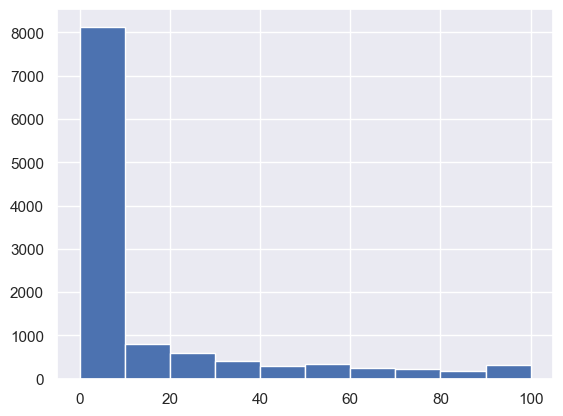

In [22]:
df.PanelReactiveAntibody_CPRA_CAN_average.hist()

##### Box-Cox transformation

In [32]:
# from scipy import stats

# # series
# series = df.TotalBilirubin_DON.dropna()

# # removing 
# series = series + 1

# # apply Box-Cox transformation
# data, lambda_optimal = stats.boxcox(series)

# # Plot the original data
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# sns.histplot(series, kde=True)
# plt.title('Original Data Distribution')

# # Plot the transformed data
# plt.subplot(1, 2, 2)
# sns.histplot(data, kde=True)
# plt.title(f'Transformed Data (lambda={lambda_optimal:.2f})')

# plt.tight_layout()
# plt.show()

In [22]:
# use mode to impute missing values
df[['PanelReactiveAntibody_CPRA_CAN_average']] = df[['PanelReactiveAntibody_CPRA_CAN_average']].fillna(0)

##### TotalBilirubin_difference
- Total bilirubin is a medical test measurement that reflects the level of bilirubin in a patient's blood. Bilirubin is a yellow compound that occurs in the body as a byproduct of red blood cell breakdown, primarily processed in the liver. The measurement is used to assess liver function, blood health, and the body's ability to break down and remove bilirubin from the bloodstream.

##### Hemodynamics

In [26]:
# get all Hemodynamics features
Hemodynamics = df.columns[df.columns.str.contains('Hemodynamics')].to_list()

##### Display NaNs

In [42]:
# display NaNs
DFNaN = percentageNull(df)

# display
DFNaN

,percentage,NaNCount
Peak_CPRA,24.617197,3762
Recent_CPRA,24.519042,3747
TransplantSurvivalDay_CAN,2.781050,425
PrimaryPaymentSourceAfter_CAN,2.663264,407
ReferralAdmission_CAN_difference,2.493129,381
CombinedMeds,1.864939,285
LungPO2_FIO2_DON,1.629368,249
LungPO2_DON,1.269467,194
Level_SGOT_ALT_DON,1.230205,188
Level_SGOT_AST_DON,1.230205,188


In [36]:
# display msg only
datatypeDF(df)
# initialize list variables for feature names
boolCol, catCol, objCol, numCol = datatypeDF(df, False)

Total Data feature count:  279

Boolean feature count: 32
Category feature count: 169
Numeric feature count: 77
Object feature count: 1

Total feature count:  279


In [41]:
# df[numCol].hist(figsize=(40,30));

##### Box-Cox transformation

In [59]:
# from scipy import stats

# # apply Box-Cox transformation
# data_LungPO2_DON, lambda_optimal = stats.boxcox(df['LungPO2_DON'])

# # Plot the original data
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# sns.histplot(data, kde=True)
# plt.title('Original Data Distribution')

# # Plot the transformed data
# plt.subplot(1, 2, 2)
# sns.histplot(data_LungPO2_DON, kde=True)
# plt.title(f'Transformed Data (lambda={lambda_optimal:.2f})')

# plt.tight_layout()
# plt.show()


### Remove NaNs

In [60]:
# remove NaNs
df = df.dropna()

# display shape
print(df.shape)

(11122, 279)


#### Category Remove with Zero Counts

In [ ]:
# remove category with zero counts
df  = removeCatZeroCount(df)

### Save to Disk

In [ ]:
# full dataframe
df.to_pickle("../Data/CleanremovedNaNs.pkl")

#### Examine Labels

In [ ]:
# display data dictionary information
df_dict[df_dict.featureName.isin(df_label.label.to_list())]

### Wrangle Data

#### Consoldate Label Features

In [ ]:
# create feature drop list
dropCol = list()

#### Mapping

In [ ]:
# AcuteRejectionEpisode_CAN
mapping = {'No': False, 'Yes, at least one episode treated with anti-rejection agent': True,'Yes, none treated with additional anti-rejection agent':True}

# new feature
df['AcuteRejection_CAN'] = df['AcuteRejectionEpisode_CAN'].map(mapping)

# add to list
dropCol.extend(['AcuteRejectionEpisode_CAN'])

# add to DataFrame (house keepping)
df_can.loc[len(df_can)] = 'AcuteRejection_CAN'
df_new.loc[len(df_new)] = 'AcuteRejection_CAN'

#### LastFollowupNumber_CAN (REMOVE)
- Unable to determine 800 & 998 & 999

In [ ]:
# add to drop list
dropCol.extend(['LastFollowupNumber_CAN'])

# display data dictionary
df_dict[df_dict.featureName.str.contains('LastFollowupNumber_CAN')]

In [ ]:
# display features that were used to create NEW features
print(sorted(df_remove.remove.to_list()))

In [ ]:
# display NEW features
print(sorted(df_new.new.to_list()))

In [ ]:
df[['ReferralAdmission_CAN_difference','LengthOfStay_CAN']].corr()

In [ ]:
df.ReferralAdmission_CAN_difference.describe()

In [ ]:
df.AcuteRejection_CAN.value_counts()

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif